# Exploring ODF Extraction - Data Analysis
## Sam Potter
## Current: 4/15/19

## Path and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\Github\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/Github/psfdi'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.stats import beta
from scipy.stats import sem

## Magics

In [2]:
%matplotlib inline

## Load Raw Intensity pSFDI Data

### Specify file paths

In [3]:
sample_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.15.19c\\2) pSFDI\\Sample\\Vertical\\Green'
standard_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.15.19c\\1) Standard\\Standard\\Vertical\\Green'

### Load mask

In [4]:
xrange, yrange = fileIO.read_psfdi_mask(sample_data_path)

### Specify spatial frequency and polarizer resolution

In [5]:
sfx_per = 37.1622
polar_res = 4
polar_max = 360

### Load and crop sample data

In [6]:
sample_dark, sample_planar, sample_I0, sample_I120, sample_I240 = fileIO.read_raw_psfdi(sample_data_path, xrange, yrange, sfx_per, polar_res, polar_max)

### Visualize

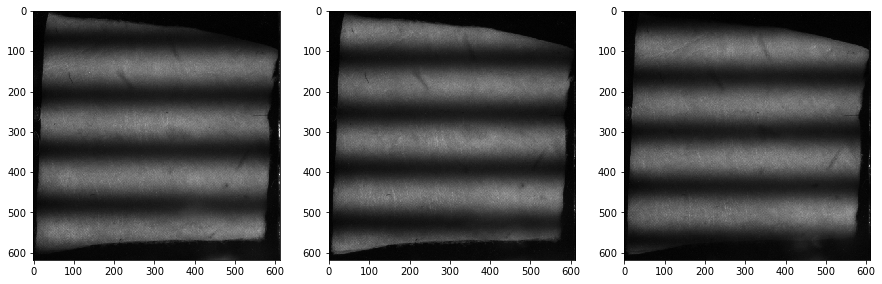

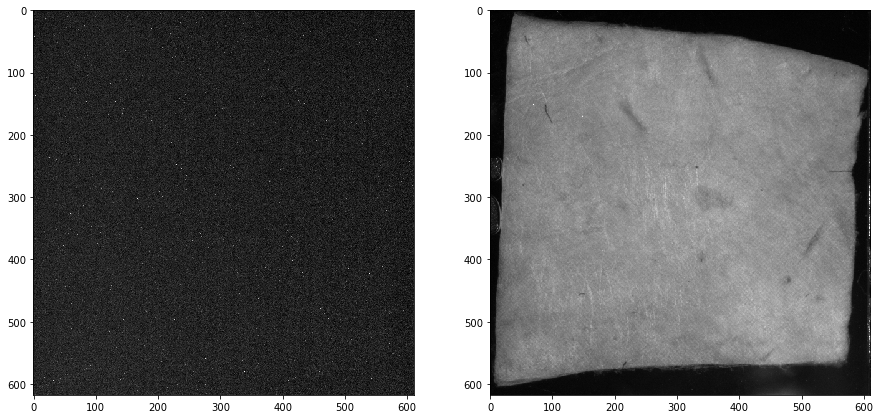

In [7]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 15))
ax0.imshow(sample_I0[0, :, :], cmap='gray');
ax1.imshow(sample_I120[0, :, :], cmap='gray');
ax2.imshow(sample_I240[0, :, :], cmap='gray');

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_dark[0, :, :], cmap='gray')
ax1.imshow(sample_planar[0, :, :], cmap='gray');

### Load and crop standard images

### Median filter standard and dark images

### Demodulate Images

In [8]:
sample_IDC, sample_IAC = imp.demodulate(sample_I0, sample_I120, sample_I240, polar_res, polar_max)

### Visualize

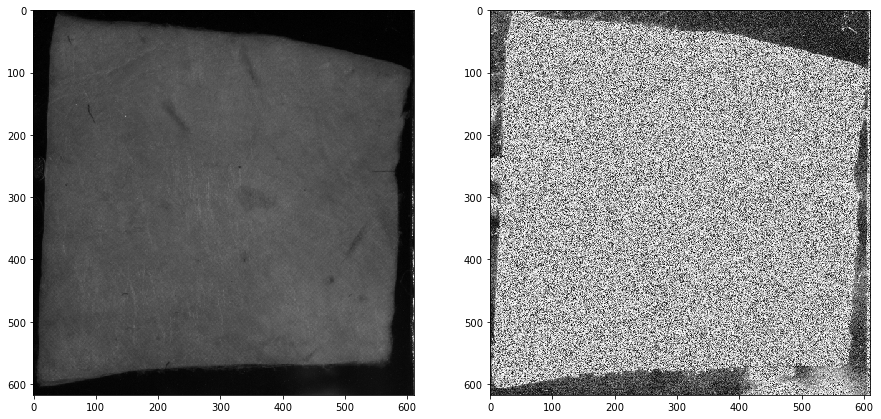

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
ax0.imshow(sample_IDC[0, :, :], cmap='gray')
ax1.imshow(sample_IAC[0, :, :], cmap='gray');

### Subtract out dark images

## Load in SALS data

In [10]:
SALS_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\SALSA OUT TXT\\BP_ODF_Extraction_032919_SALSA.txt'

SALS_data_dict = fileIO.read_SALS(SALS_data_path)

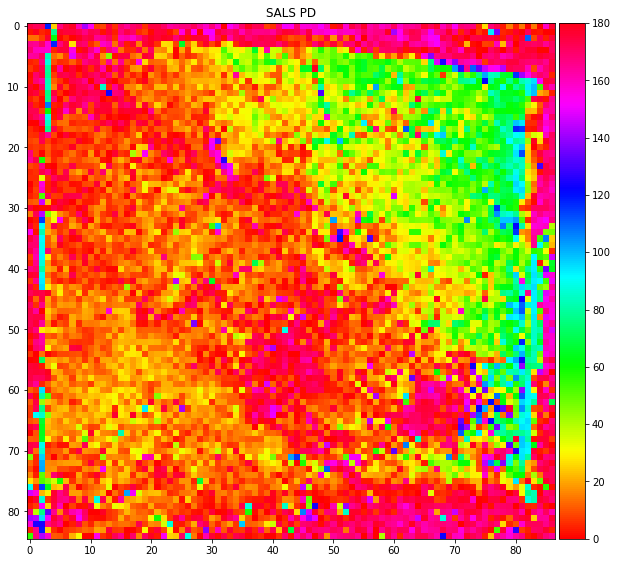

In [11]:
PD_2d = SALS_data_dict['PD']
# SALS PD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

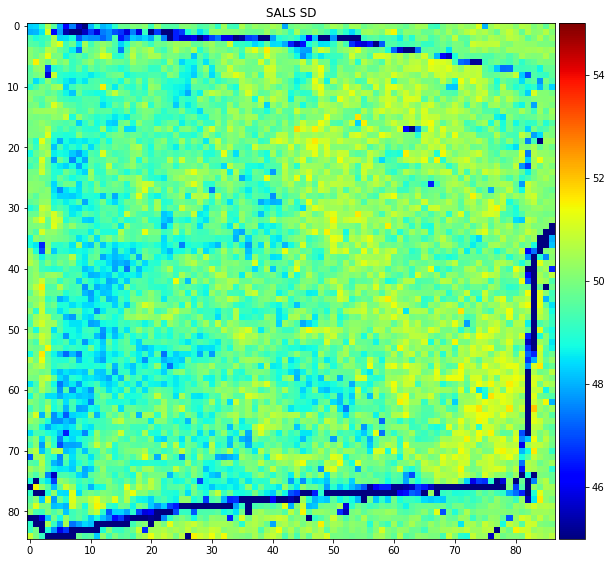

In [12]:
SD_2d = SALS_data_dict['SD']
# SALS SD
fig = plt.figure(figsize=(10, 10))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

In [13]:
# Save a file for masking a mask
name = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\Results\\BP ODF 032919\\BW_Images\\color_premask.png'
plt.imsave(name, SD_2d, format='png', cmap='jet', vmin=45, vmax=55)

## Feasibility Study - Raw Data

### No extra registration. This isn't completely correct, but okay for now. Can improve by multiplying warp matrix translation by numer of psfdi pixels in SALS pixel as a start.

## Set the row and column data from visualization etc

In [14]:
row = 20
col = 20
ydim = SALS_data_dict['PD'].shape[0]

row_step = int(sample_IDC.shape[1] / SALS_data_dict['PD'].shape[0])
col_step = int(sample_IDC.shape[2] / SALS_data_dict['PD'].shape[1])

psfdi_row = row * row_step
psfdi_col = col * col_step

index = col * ydim + (ydim - col)

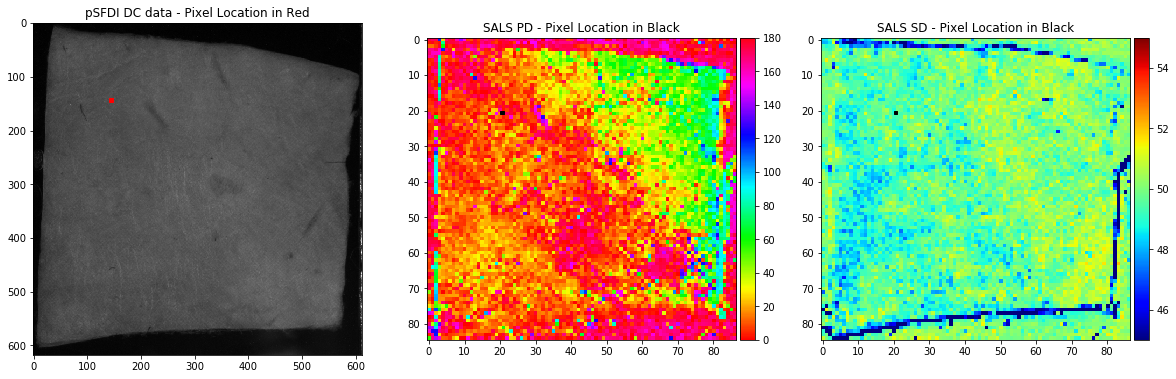

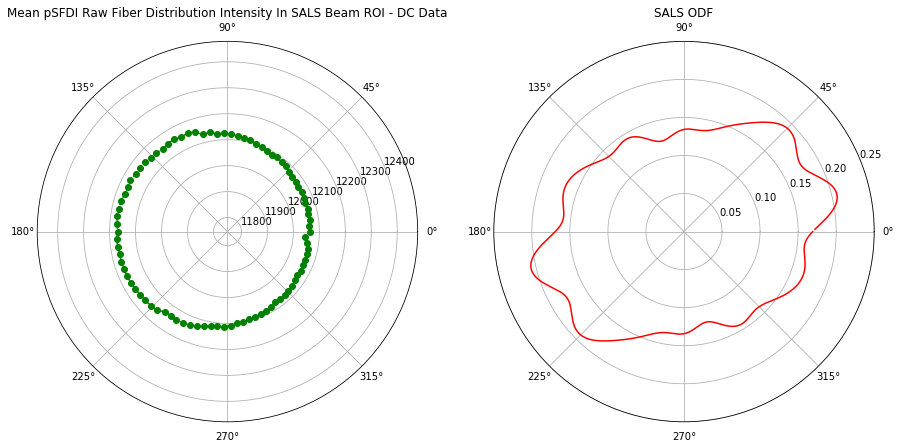

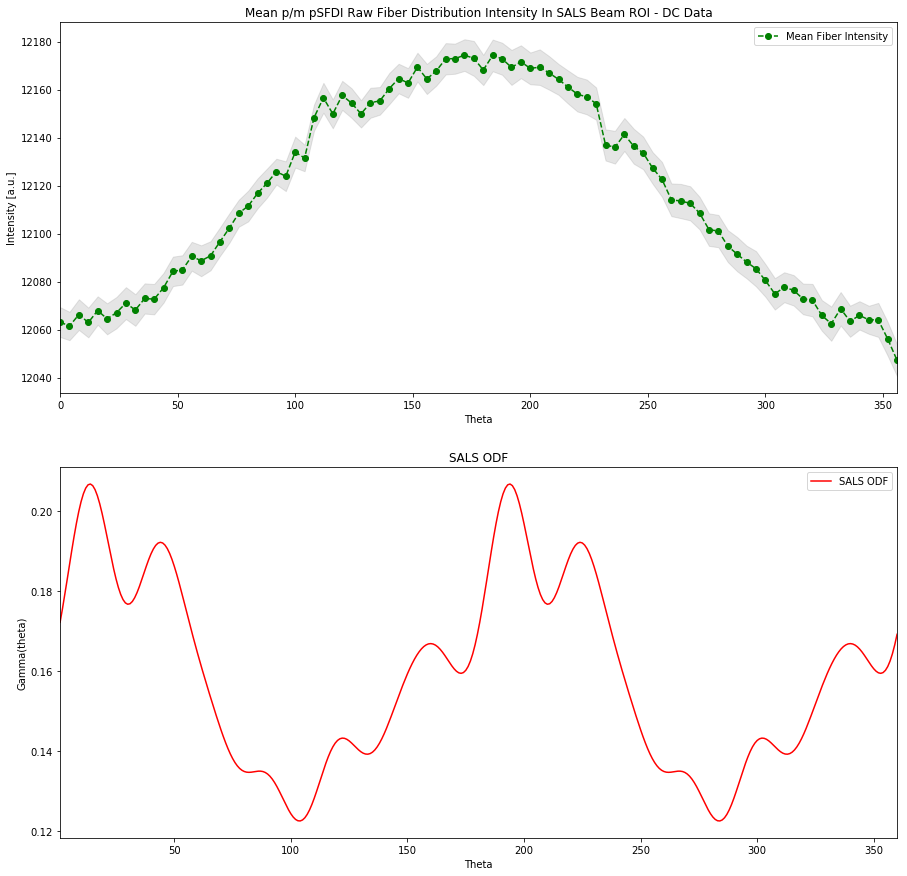

In [15]:
visualize.compare_raw_interactive_360(row, col, sample_IDC, 'DC', SALS_data_dict)

## Fourier Series Fit

### SALS Data

In [16]:
odf_theta = SALS_data_dict['theta'][index, :]
odf_gamma = SALS_data_dict['odf'][index, :]

In [17]:
an, bn, c = odf.fit_fourier(20, odf_gamma, odf_theta)
odf_fsfit = odf.compute_fourier(an, bn, c, odf_theta)

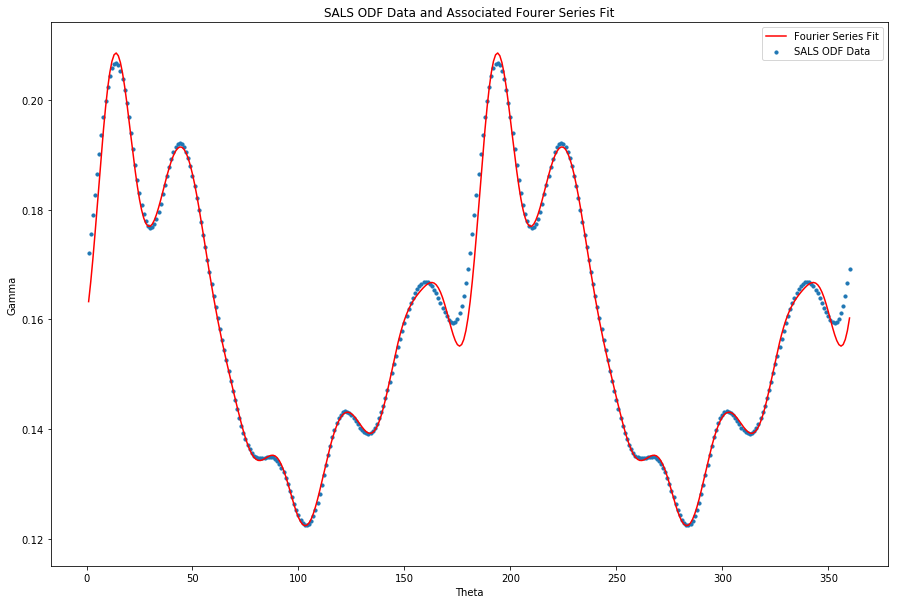

In [18]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, marker='o', s=10, label='SALS ODF Data')
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit');
plt.ylabel('Gamma');
plt.xlabel('Theta');
plt.legend()
plt.title('SALS ODF Data and Associated Fourer Series Fit');

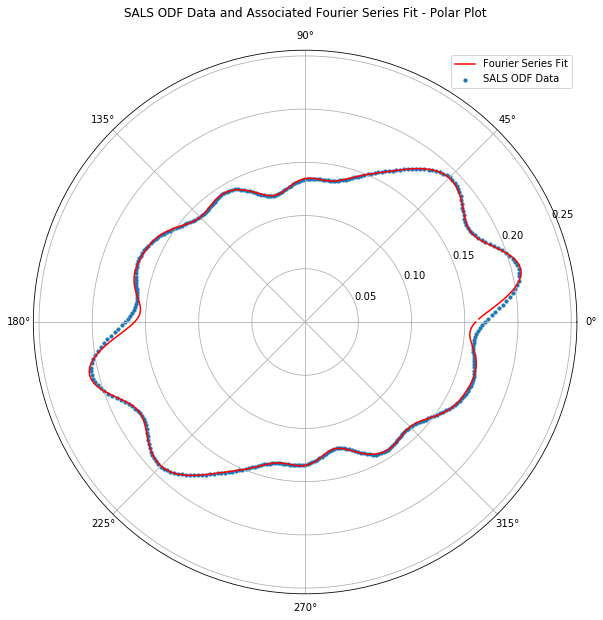

In [19]:
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.legend()
plt.title('SALS ODF Data and Associated Fourier Series Fit - Polar Plot');

## Compute the Primary and Secondary Directions

In [20]:
theta1, theta2 = odf.structural_eigenval_thetas(an[0], bn[0])

In [21]:
print('Theta I (deg): {}'.format(theta1))
print('Theta II (deg): {}'.format(theta2))

Theta I (deg): 19.726877045967672
Theta II (deg): 109.72687704596768


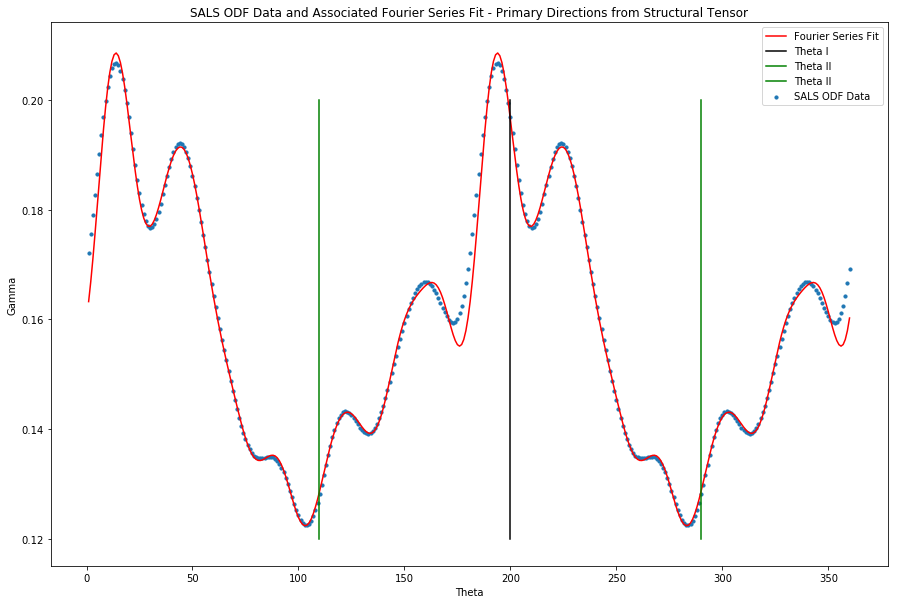

In [22]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, s=10, label='SALS ODF Data');
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit')
plt.plot((theta1 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='k', label='Theta I')
plt.plot(theta2 * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.plot((theta2 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.xlabel('Theta')
plt.ylabel('Gamma')
plt.legend();
plt.title('SALS ODF Data and Associated Fourier Series Fit - Primary Directions from Structural Tensor');

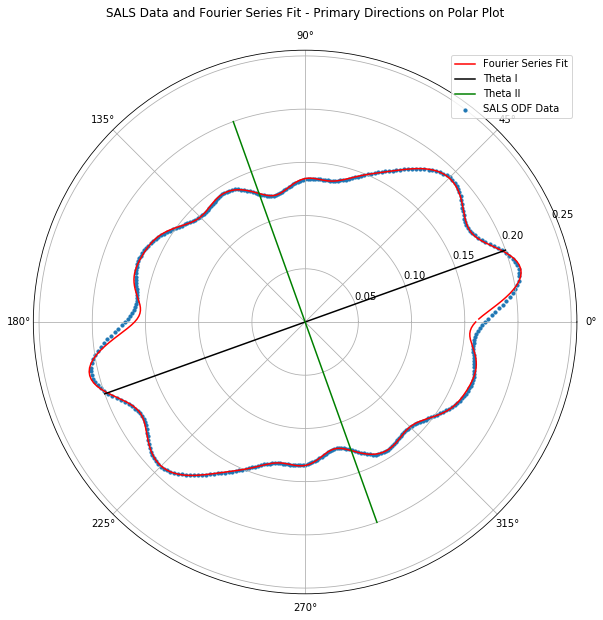

In [23]:
theta1_r = np.deg2rad(theta1)
theta2_r = np.deg2rad(theta2)
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.polar([theta1_r, theta1_r + np.pi], [0.20, 0.20], color='k', label='Theta I')
plt.polar([theta2_r, theta2_r + np.pi], [0.20, 0.20], color='g', label='Theta II')
plt.legend()
plt.title('SALS Data and Fourier Series Fit - Primary Directions on Polar Plot');

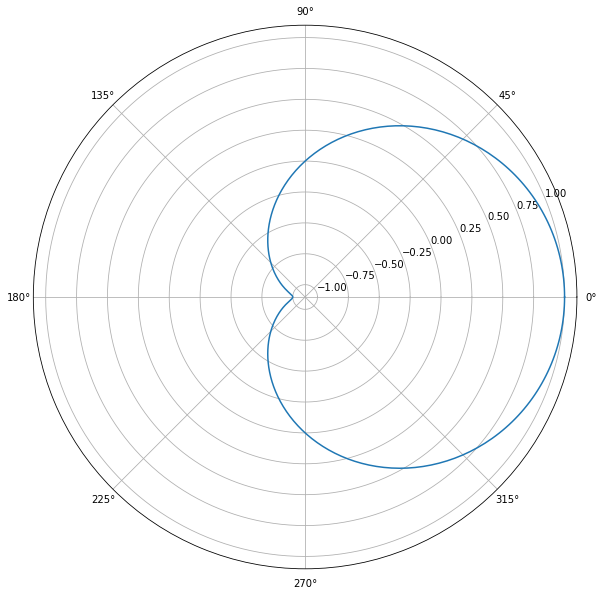

In [24]:
theta = np.deg2rad(np.linspace(0, 360, 360))
cos = np.cos(theta)

fig = plt.figure(figsize=(10, 10))
plt.polar(theta, cos)

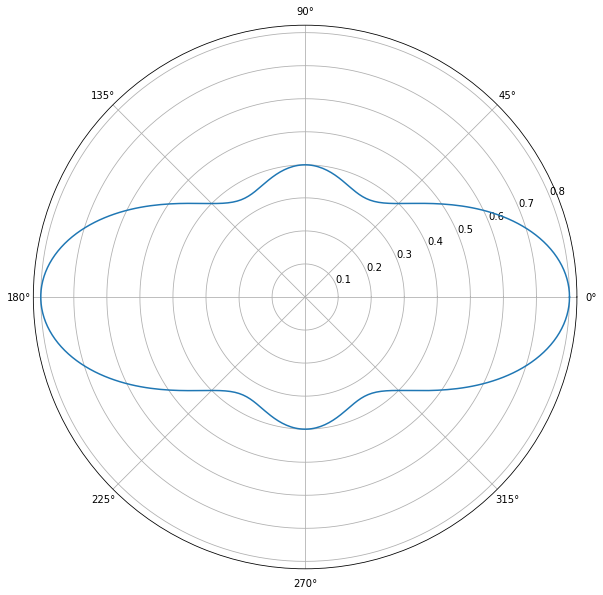

In [25]:
fiber = odf.Ifiber(0.5, 0.2, 0.1, 0, np.rad2deg(theta))
fig = plt.figure(figsize=(10, 10))
plt.polar(theta, fiber)

In [26]:
raw_data = sample_IDC[:, psfdi_row, psfdi_col]
raw_theta = np.arange(0, 360, int(360 / sample_IDC.shape[0]))

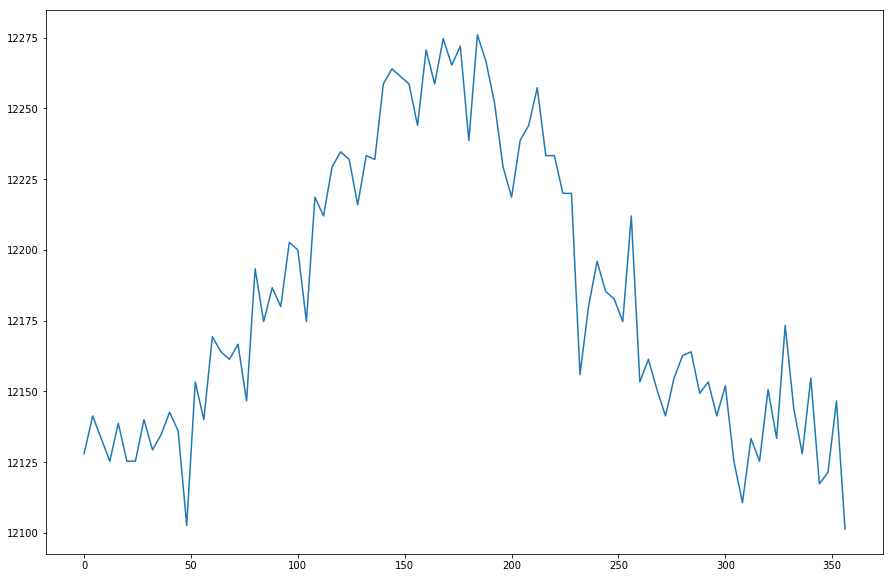

In [27]:
fig = plt.figure(figsize=(15, 10))
plt.plot(raw_theta[:], raw_data[:])